In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from scalp_utils import *
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import scipy.stats as sp_stats
plt.style.use('dark_background')
pd.options.display.precision = 10

In [3]:
# y_AH_dict = joblib.load('results/y_AH_dict_16.pkl')
# eog1_dict = joblib.load('results/eog1_dict_before_split.pkl')
# eog2_dict = joblib.load('results/eog2_dict_before_split.pkl')
# avg_dict = joblib.load('results/avg_dict_before_split.pkl')

y_AH_dict = joblib.load('results/y_dict_clean_eog_AH.pkl')
# eog1_dict = joblib.load('results/eog1_dict_clean_eog.pkl')
# eog2_dict = joblib.load('results/eog2_dict_clean_eog.pkl')
eog1_dict = joblib.load('results/eog1_dict_with_chan.pkl')
eog2_dict = joblib.load('results/eog2_dict_with_chan.pkl')


nrem_sample = {'38': 80, '394': 20, '396': 65, '398': 50, '400': 10, '402': 10, '404': 100, '405': 53, '406': 90, '414': 75, '415': 55,
               '416': 190, '417': 86, '423': 20, '426': 185, '429': 7}

# crop the relevant section of nrem
y_AH_nrem = {subj :y_AH_dict[subj][nrem_sample[subj] * 4 * 60: nrem_sample[subj] * 4 * 60 + 60 * 4 * 60] for subj in y_AH_dict.keys()}
eog1_dict_nrem = {subj: eog1_dict[subj][nrem_sample[subj] * 4 * 60: nrem_sample[subj] * 4 * 60 + 60 * 4 * 60] for subj in eog1_dict.keys()}
eog2_dict_nrem = {subj: eog2_dict[subj][nrem_sample[subj] * 4 * 60: nrem_sample[subj] * 4 * 60 + 60 * 4 * 60] for subj in eog2_dict.keys()}

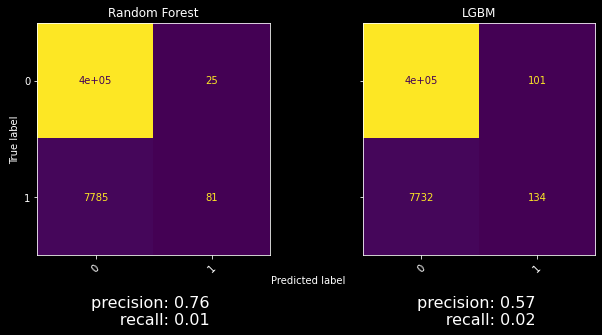

In [95]:
# EOG 1+2, regular model
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)
prob=None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [3]:
# EOG 1+2, under sample
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

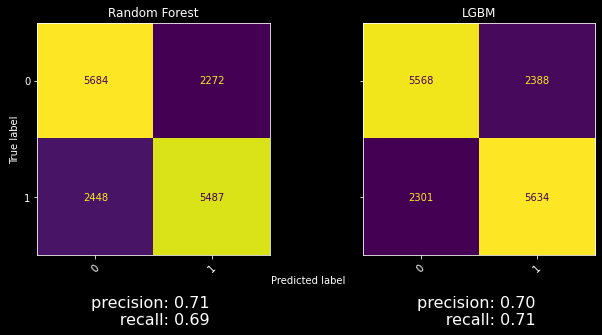

In [81]:
prob=None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

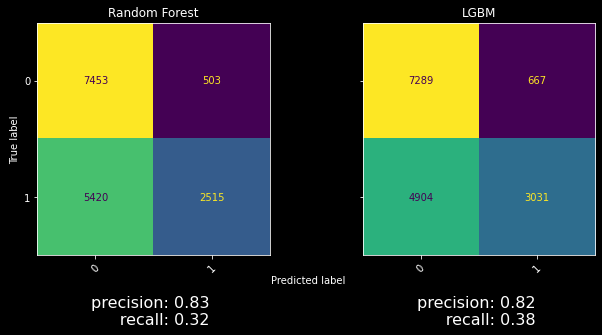

In [82]:
prob=0.7
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [83]:
joblib.dump(classifiers['Random Forest'], 'rf_undersample.pkl')
joblib.dump(classifiers['LGBM'], 'lgbm_undersample.pkl')

['lgbm_undersample.pkl']

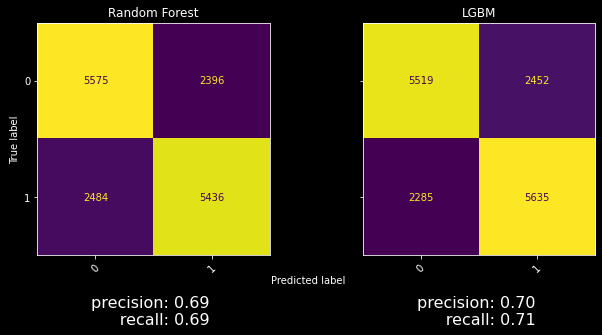

In [13]:
# precision metric
# EOG 1+2, under sample
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

prob=None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(metrics=['average_precision']),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

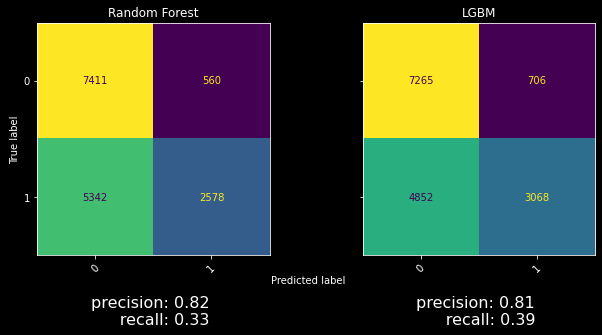

In [15]:
prob=0.7
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [22]:
classifiers['LGBM'].feature_importances_

array([ 91,  28,  55,  72,  21,  47,  75,   0,  23,  49,  52,  70,  58,
        38,  35,  60,  45,  60,  82,  33,  28,  27, 104,  33,  39,  38,
       104, 148, 116,  50,  63,  44,  32,  72,  78,   0,  24,  34,  56,
        55,  60,  24,  12,  61,  44,  66, 107,  29,  21,  26,  98,  41,
        74,  33, 120,  45])

In [82]:
details = pred_details['Random Forest']
data = details[(details['pred'] >= 0.7)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

KeyError: 'Random Forest'

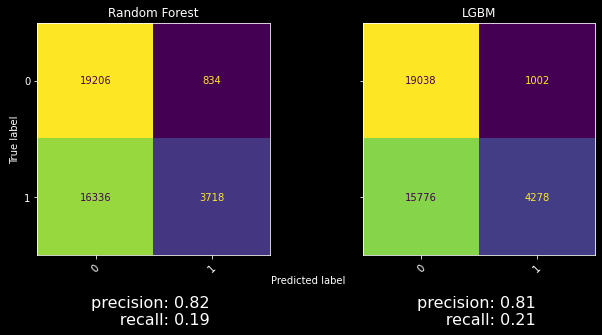

In [11]:
# try without c-min
# X_train, X_test, y_train, y_test
prob = 0.7
x_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = X_test[x_train_data.columns]
f, axes = plt.subplots(1, len(cls), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(cls.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [32]:
feature_names = pd.DataFrame(classifiers['LGBM'].feature_name_)
feature_names['imp'] = classifiers['LGBM'].feature_importances_
feature_imp = feature_names.sort_values(by=['imp'], ascending=False)
feature_imp.head(60)

,0,imp
27,ptp,148
54,median_2,120
28,std_2,116
46,gf_2,107
22,abspow,104
26,median,104
50,abspow_2,98
0,std,91
18,gf,82
34,hcomp_2,78


In [36]:
list(feature_imp.iloc[:, :15][0])

['ptp',
 'median_2',
 'std_2',
 'gf_2',
 'abspow',
 'median',
 'abspow_2',
 'std',
 'gf',
 'hcomp_2',
 'hcomp',
 'higuchi_2',
 'hmob_2',
 'kurt',
 'beta',
 'bf_2',
 'skew_2',
 'ag_2',
 'gamma_2',
 'ag',
 'bf',
 'gamma',
 'sigma_2',
 'skew',
 'beta_2',
 'sigma',
 'iqr_2',
 'alpha',
 'hmob',
 'sf',
 'ptp_2',
 'sf_2',
 'kurt_2',
 'perm_2',
 'higuchi',
 'fast',
 'petrosian',
 'at',
 'alpha_2',
 'perm',
 'petrosian_2',
 'gt',
 'nzc_2',
 'gt_2',
 'iqr',
 'ft',
 'af',
 'af_2',
 'fast_2',
 'theta_2',
 'theta',
 'nzc',
 'ft_2',
 'at_2',
 'delta_2',
 'delta']

In [ ]:
import shap
explainer = shap.Explainer(cls['Random Forest'])
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.beeswarm(shap_values)

In [20]:
def channel_feat(chan):

    feat = {
        'median': np.median(chan),
        'ptp': np.ptp(chan),
        # 'iqr': sp_stats.iqr(chan),
        # 'skew': sp_stats.skew(chan),
        # 'kurt': sp_stats.kurtosis(chan),
        # bf, gf
    }

    feat = pd.DataFrame(feat, index=[0])

    return feat

In [ ]:
all_chans = []
for subj in ['396', '398', '402', '406', '415', '416']:
    raw_data = mne.io.read_raw_edf(scalp_edf_path % subj).pick_channels(['EOG1']).resample(sr).get_data()[0]
    raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    chan_feat = calc_features_before_split([raw_data], subj)
    all_chans.append(chan_feat)

In [4]:
pd.concat(all_chans)

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,delta,...,sf,bf,gf,gt,ft,af,abspow,perm,higuchi,petrosian
0,396,0,1.0000000200,0.8615200658,-0.1075328316,8.3853662682,134144,0.0170336700,60.3386850132,0.0,...,0.0,8.0481613315,5.1009070538,inf,inf,inf,0.0548453825,0.6247946856,1.0201861511,1.0025641254
0,398,0,1.0000000298,0.8970824184,0.3808407464,9.1585201193,89800,0.0169561765,61.8628580661,0.0,...,0.0,9.5328571997,8.4732187289,inf,inf,inf,0.0439284308,0.6321680586,1.0318599618,1.0027366854
0,402,0,1.0000000215,0.9137776303,-0.2703581146,12.7628500607,113298,0.0166171941,64.4862682934,0.0,...,0.0,6.8064524207,6.6317098437,inf,inf,inf,0.0447673069,0.6532831291,1.0241239929,1.0030053258
0,406,0,1.0000000229,0.9869419978,-0.0223244979,5.7477447534,143034,0.0201341501,44.3087916255,0.0,...,0.0,24.4639577172,17.7899875819,inf,inf,inf,0.0521334397,0.5763840675,1.0366017992,1.0019072125
0,415,0,1.0000000187,0.8476346943,0.1113899972,7.5503719815,161414,0.0178991314,53.5411689820,0.0,...,0.0,11.3659478305,5.7622871277,inf,inf,inf,0.0559540204,0.5879765455,1.0211848666,1.0020378765
0,416,0,1.0000000187,0.7983140246,0.4682389538,20.5434109717,132828,0.0164897739,64.9587848128,0.0,...,0.0,10.6492624980,7.5710861186,inf,inf,inf,0.0356554569,0.7305855746,1.0364265733,1.0042811217


In [21]:
all_chans = []
for subj in ['396', '398', '402', '406', '415', '416']:
    raw_data = mne.io.read_raw_edf(scalp_edf_path % subj).pick_channels(['EOG1']).resample(sr).get_data()[0]
    raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    chan_feat = channel_feat(raw_data)
    all_chans.append(chan_feat)

pd.concat(all_chans)

Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\396_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\398_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\402_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\406_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\415_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\416_clean.edf...
EDF file detected
Setting channel

,std,min,max,mean,median,ptp,argmin,argmax,var,mean_s,r_mean_s
0,1.0000000200,-10.2320955479,11.6247564474,-1.2953565960e-17,-0.0000127563,21.8568519953,2680613,2616207,1.0,1.0,1.0
0,1.0000000298,-10.6444457791,9.8139329662,2.3885610022e-17,-0.0138579305,20.4583787453,16749233,7587602,1.0,1.0,1.0
0,1.0000000215,-12.4439740100,14.3642136469,1.2125031503e-17,0.0067460419,26.8081876568,7675424,7785777,1.0,1.0,1.0
0,1.0000000229,-9.7903853035,9.8534084975,-2.2190776159e-17,-0.0034088415,19.6437938010,2508894,2394838,1.0,1.0,1.0
0,1.0000000187,-9.4619512670,9.5615912840,-1.2016613460e-17,-0.0036342483,19.0235425510,17412244,686938,1.0,1.0,1.0
0,1.0000000187,-15.0526281661,16.5329325317,-1.1689770726e-17,-0.0001859868,31.5855606978,9595704,678926,1.0,1.0,1.0


In [22]:
all_chans = []
for subj in ['396', '398', '402', '406', '415', '416']:
    raw_data = mne.io.read_raw_edf(scalp_edf_path % subj).pick_channels(['EOG2']).resample(sr).get_data()[0]
    raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    chan_feat = channel_feat(raw_data)
    all_chans.append(chan_feat)

pd.concat(all_chans)

Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\396_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\398_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\402_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\406_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\415_clean.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\PycharmProjects\pythonProject\416_clean.edf...
EDF file detected
Setting channel

,std,min,max,mean,median,ptp,argmin,argmax,var,mean_s,r_mean_s
0,1.0000000200,-10.6954923551,14.0614771231,2.0401154505e-18,0.0059625993,24.7569694781,2616107,12992316,1.0,1.0,1.0
0,1.0000000298,-11.2599220644,10.7814545552,4.0960300632e-17,-0.0042564352,22.0413766196,16084210,230695,1.0,1.0,1.0
0,1.0000000215,-14.3662279717,15.2284661423,-2.5345227143e-17,0.0002866794,29.5946941140,7393751,7675608,1.0,1.0,1.0
0,1.0000000229,-9.8409974626,9.7485843940,1.3597829148e-17,0.0042218760,19.5895818566,2435777,2441037,1.0,1.0,1.0
0,1.0000000187,-9.8395689021,10.6533646325,4.6844425352e-18,-0.0040810893,20.4929335347,17412272,1555961,1.0,1.0,1.0
0,1.0000000187,-11.8910051903,15.5927569131,9.1617941827e-18,-0.0007837152,27.4837621034,25768093,9444307,1.0,1.0,1.0


### LOO with NREM ###

C:\repos\spikes_notebooks\depth_utils.py:76: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])


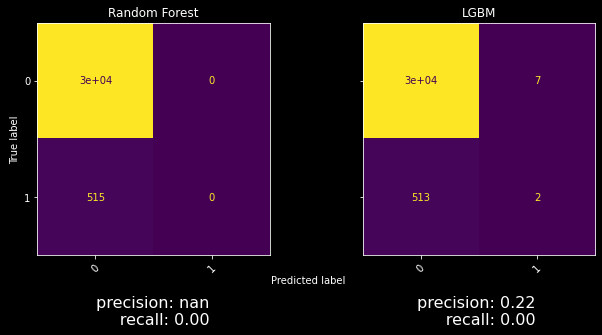

In [53]:
# generalization
all_subject = ['417']
# all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
out_subj = '415'
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x != out_subj])
for subj in all_subject:
    if subj != out_subj:
        curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
# feat_all_good['y'] = y_all_good.astype(int)
# feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
# feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
# feat_under = pd.concat([feat_0, feat_1])
# y_all_good = feat_under['y'].to_numpy()
# feat_all_good = feat_under.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
# X_train_after = calc_features_after_split(X_train)
# X_test_after = calc_features_after_split(X_test)

x_train, x_test, y_train, y_test, prob = X_train, X_test, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
# selector = VarianceThreshold(.1)
# selector.fit_transform(x_train_data)
# x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
# x_test_data = x_test[x_train_data.columns]
x_test_data = x_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

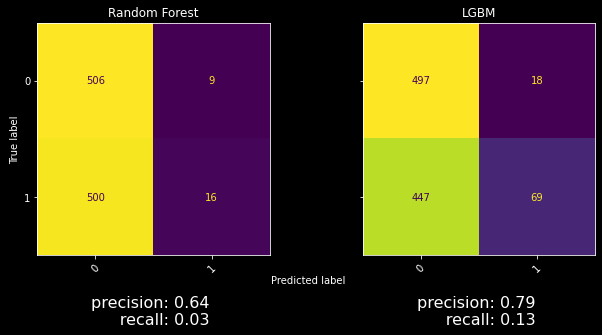

In [47]:
prob = 0.8
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

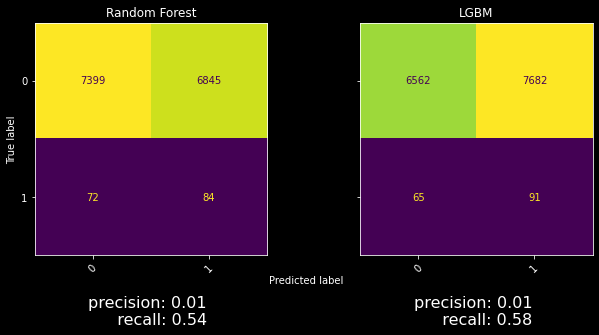

In [51]:
# out subject
y_out = y_AH_nrem[out_subj]
feat_out = pd.concat([eog1_dict_nrem[out_subj], eog2_dict_nrem[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)

# Add norm values
# feat_out = calc_features_after_split(feat_out)
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

feat_out_data = feat_out.iloc[:, 2:]
# feat_out_data = feat_out_data[classifiers['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(feat_out_data)
    cf_matrix = confusion_matrix(y_out, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

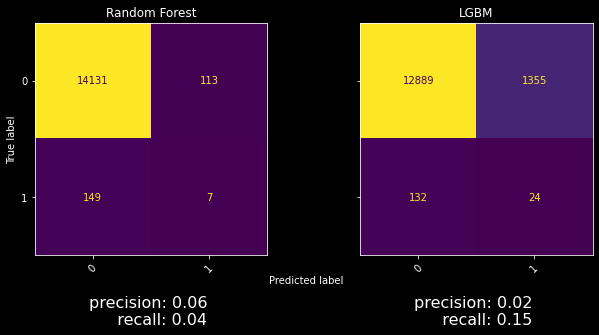

In [52]:
prob = 0.80
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict_proba(feat_out_data).T
    cf_matrix = confusion_matrix(y_out, [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

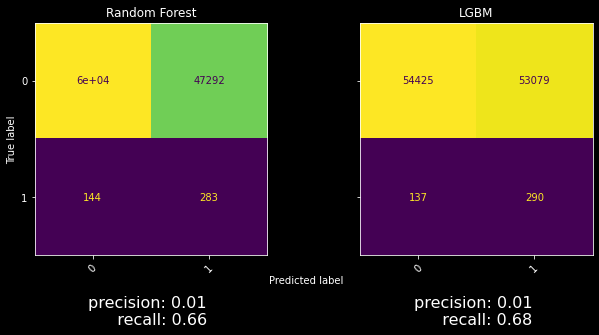

In [49]:
# out subject
y_out = y_AH_dict[out_subj]
feat_out = pd.concat([eog1_dict[out_subj], eog2_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)

# Add norm values
# feat_out = calc_features_after_split(feat_out)
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

feat_out_data = feat_out.iloc[:, 2:]
# feat_out_data = feat_out_data[classifiers['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(feat_out_data)
    cf_matrix = confusion_matrix(y_out, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

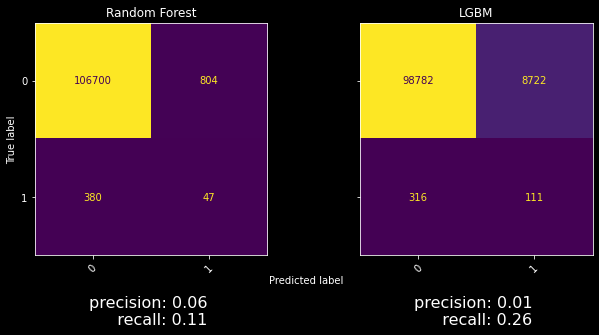

In [50]:
prob = 0.80
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict_proba(feat_out_data).T
    cf_matrix = confusion_matrix(y_out, [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [88]:
feat_out

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,delta,...,gf_2,gt_2,ft_2,af_2,abspow_2,perm_2,higuchi_2,petrosian_2,median_2,ptp_2
19200,38,19200,0.2337896567,0.3237378076,0.0428085880,-0.4100391498,2,0.0870612341,2.3155545689,0.0,...,3489.2276279232,0.1061592760,0.0000304249,0.0000328891,0.0769173916,0.4928258754,1.0402490075,1.0028831344,-0.000000124,0.0009436247
19201,38,19201,0.2639196434,0.4279074114,-0.1943713039,-0.9090418833,5,0.1363164944,8.0079574537,0.0,...,389.0630224028,0.0482809832,0.0001240955,0.0001276953,0.0773262242,0.6661907104,1.0437802470,1.0102465672,-0.000000124,0.0009436247
19202,38,19202,0.1563576974,0.2368177274,0.1810681278,-0.8971641423,0,0.1143338468,2.3157911575,0.0,...,543.6374794135,0.2100567114,0.0003863912,0.0001614628,0.0214436018,0.5500522150,1.0331267940,1.0048841654,-0.000000124,0.0009436247
19203,38,19203,0.2403029749,0.3802317386,0.0880073692,-0.8602285564,0,0.0594273407,4.1886604220,0.0,...,1647.0526942906,0.0444842255,0.0000270084,0.0000387872,0.0575050505,0.5795806111,1.0399276250,1.0063049914,-0.000000124,0.0009436247
19204,38,19204,0.1547479914,0.1694225534,-0.0219307004,0.0697562314,0,0.1048249605,2.2057798896,0.0,...,1278.9515725989,0.1069106560,0.0000835924,0.0005320770,0.0196503409,0.6596385331,1.0516148083,1.0096867497,-0.000000124,0.0009436247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,38,33595,0.2856191894,0.3353368033,-0.1025804865,-0.5665420172,1,0.0371331847,8.0875433680,0.0,...,316.7425040547,0.0132870671,0.0000419491,0.0000761759,0.0318222001,0.5974777421,1.0348145930,1.0068713676,-0.000000124,0.0009436247
33596,38,33596,0.2199285193,0.3389350757,0.2650942734,-0.8335870426,4,0.0563166395,4.4754404966,0.0,...,827.4842821562,0.0418544365,0.0000505803,0.0000794248,0.0271124825,0.5716671173,1.0596258058,1.0057375016,-0.000000124,0.0009436247
33597,38,33597,0.2085499029,0.2986323351,-0.0235016367,-0.6909026184,6,0.0585080172,4.4173049734,0.0,...,212.8735947112,0.0681951805,0.0003203553,0.0001998960,0.0097214036,0.5868152372,1.1028520985,1.0063049914,-0.000000124,0.0009436247
33598,38,33598,0.4533505267,0.7427083960,-0.2901550752,-1.0714282448,1,0.0358812753,5.6766821177,0.0,...,387.6661327243,0.0088009865,0.0000227025,0.0000448728,0.0822133700,0.6127998573,1.0176543666,1.0080008025,-0.000000124,0.0009436247


In [37]:
from sklearn.manifold import TSNE
X = feat_all_good[list(feature_imp.iloc[:, :15][0])]
Y = y_all_good
X_TSNE = TSNE().fit_transform(X)
vis_x = X_TSNE[:, 0]
vis_y = X_TSNE[:, 1]

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


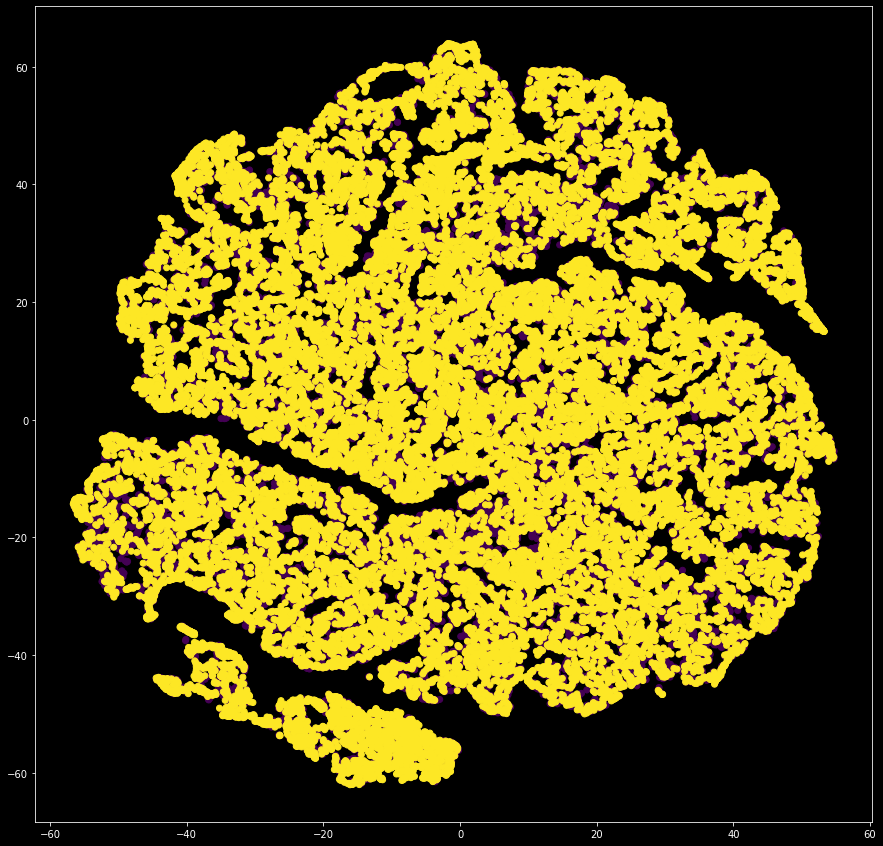

In [38]:
plt.figure(figsize=(15,15))
plt.scatter(vis_x, vis_y, c=Y)

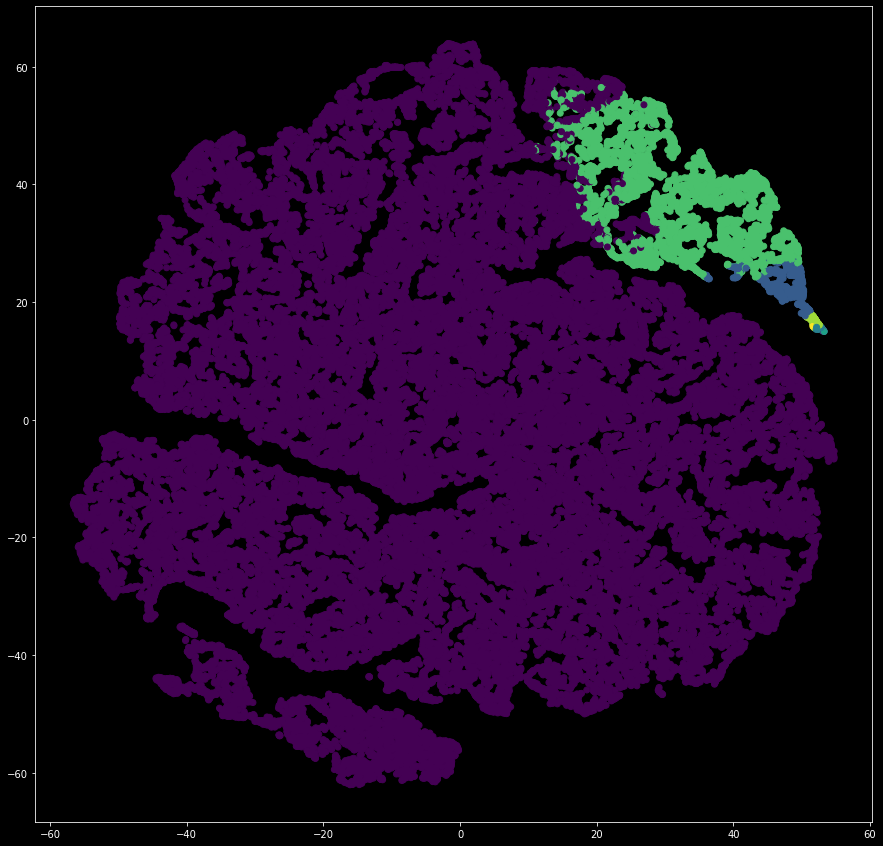

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=0).fit(X)
clusters = kmeans.predict(X)
plt.figure(figsize=(15,15))
plt.scatter(vis_x, vis_y, c=clusters)

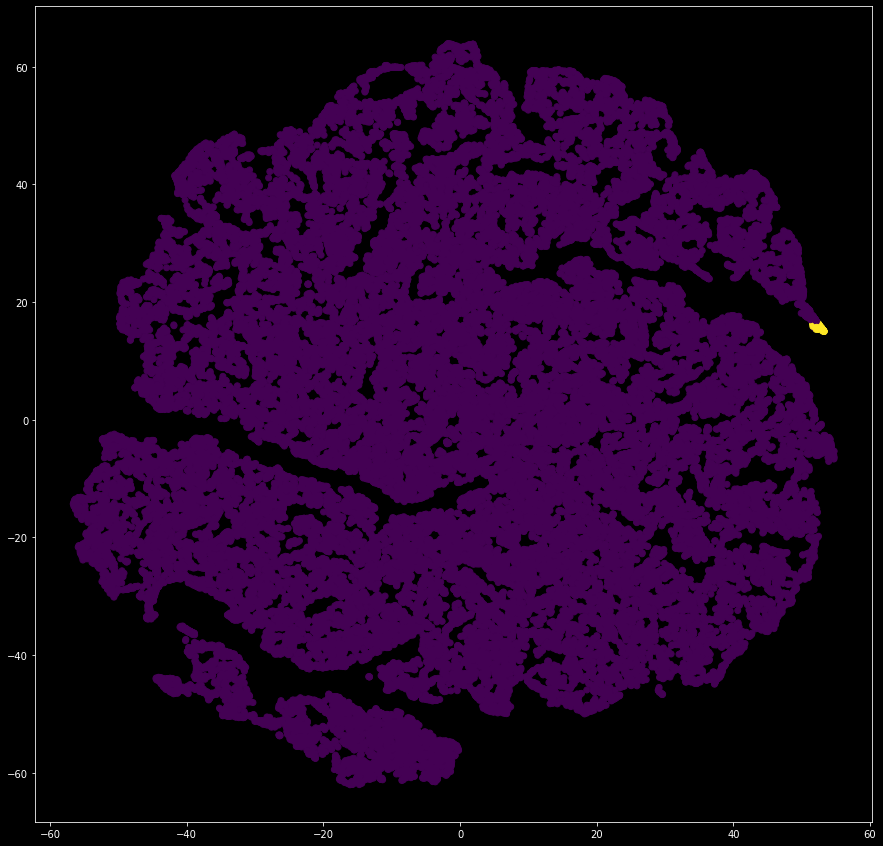

In [43]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
clusters = kmeans.predict(X)
plt.figure(figsize=(15,15))
plt.scatter(vis_x, vis_y, c=clusters)

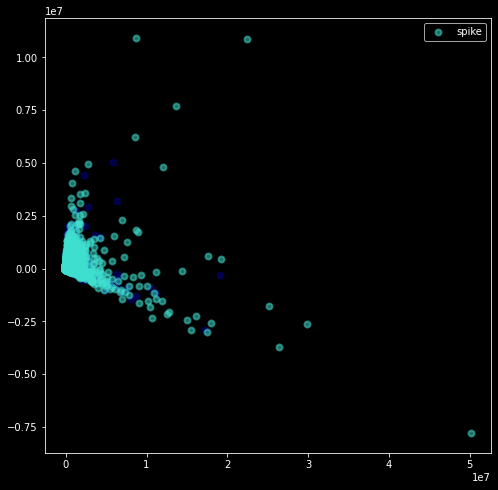

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

colors = ["navy", "turquoise"]


plt.figure(figsize=(8, 8))
for color, i in zip(colors, [0, 1]):
    plt.scatter(
        X_pca[Y == i, 0],
        X_pca[Y == i, 1],
        color=color,
        alpha=0.5,
        lw=2,
        label='spike' if i == 1 else None,
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.axis([-4, 4, -1.5, 1.5])

plt.show()

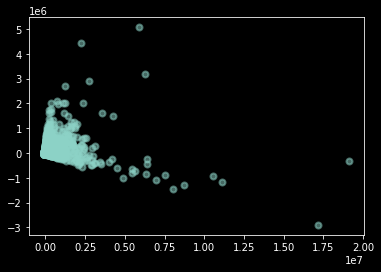

In [45]:
plt.scatter(
        X_pca[Y == 0, 0],
        X_pca[Y == 0, 1],
        alpha=0.5,
        lw=2,
        label='spike' if i == 1 else None,
    )

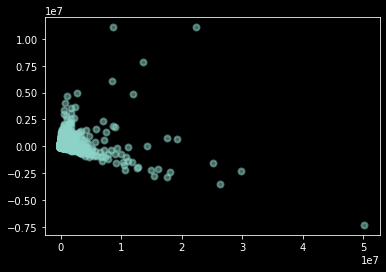

In [130]:
plt.scatter(
    X_pca[Y == 1, 0],
    X_pca[Y == 1, 1],
    alpha=0.5,
    lw=2,
    label='spike' if i == 1 else None,
)

In [129]:
X_pca[Y == 1, 0]

array([-81514.61510696, -55978.12410908, -74093.10483696, ...,
       -82037.60430301, -80076.59853895, -80775.71132527])

In [133]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train_data, y_train)
y_pred = rf.predict(x_test_data)

NameError: name 'sklearn' is not defined

In [4]:
import sklearn
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      7945
           1       0.70      0.68      0.69      7946

    accuracy                           0.70     15891
   macro avg       0.70      0.70      0.70     15891
weighted avg       0.70      0.70      0.70     15891



In [135]:
rf.feature_importances_

array([0.03121062, 0.02262649, 0.01792091, 0.01855534, 0.00762595,
       0.01805344, 0.01883859, 0.        , 0.01580734, 0.01599109,
       0.01738222, 0.01776705, 0.01741312, 0.01387087, 0.01565177,
       0.01703322, 0.01865008, 0.02068609, 0.02033568, 0.0166788 ,
       0.0144882 , 0.01529085, 0.03262207, 0.01913497, 0.01813751,
       0.0147918 , 0.02720349, 0.04008033, 0.02768697, 0.0211048 ,
       0.01799725, 0.01829321, 0.00720212, 0.01798661, 0.01887911,
       0.        , 0.01551335, 0.01646612, 0.01715157, 0.01734531,
       0.01702771, 0.01300336, 0.01536892, 0.01707431, 0.01834286,
       0.01933479, 0.02094094, 0.01658872, 0.01417746, 0.01495345,
       0.02662176, 0.01824379, 0.01819598, 0.01403554, 0.015586  ,
       0.02103013])

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bf', ylabel='Density'>

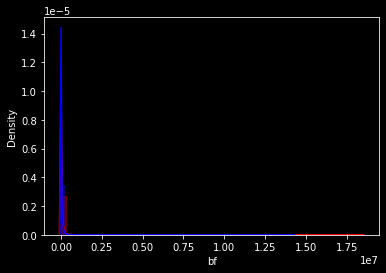

In [153]:
# std, abspow, iqr, bf, gf, hcomp
import seaborn as sns
plt.figure()
ax = plt.subplot()
df = feat_all_good
df['y'] = y_all_good.astype(int)
sns.distplot(df[(df.y==1)]['bf'], bins=50, color='r')
sns.distplot(df[(df.y==0)]['bf'], bins=50, color='b')

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bf', ylabel='Density'>

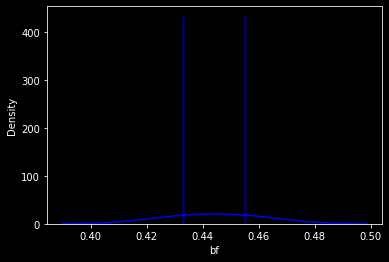

In [151]:
sns.distplot(df[(df.y==1) & (df['bf'] < 0.5)]['bf'], bins=20, color='r')
sns.distplot(df[(df.y==0) & (df['bf'] < 0.5)]['bf'], bins=20, color='b')

In [154]:
df['bf'].describe()

count    6.3562000000e+04
mean     3.5400941486e+04
std      2.1048151119e+05
min      4.3267126397e-01
25%      1.5547439483e+03
50%      6.0861366446e+03
75%      2.1586514708e+04
max      1.8462932818e+07
Name: bf, dtype: float64

In [156]:
df[(df.y==1)]['std'].describe()

count    31781.0000000000
mean         0.3713691758
std          0.2758024810
min          0.0237762638
25%          0.1950886178
50%          0.3022480207
75%          0.4628079914
max          5.4911249594
Name: std, dtype: float64

In [157]:
df[(df.y==0)]['std'].describe()

count    31781.0000000000
mean         0.2727233761
std          0.2026357905
min          0.0204324963
25%          0.1440556694
50%          0.2209334366
75%          0.3373943298
max          3.3131114364
Name: std, dtype: float64

In [57]:
sample_size = []
precision = []
recall = []
f_one = []
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

for size in range(31781, 31781 * 30, 5000):
    print('Running : size = %d' % (size))
    sample_size.append(size)
    for_resample = feat_all_good.copy()
    for_resample['y'] = y_all_good.astype(int)
    # under sampling non-spikes epochs
    feat_0 = for_resample[for_resample['y'] == 0].sample(n=size, random_state=0)
    feat_1 = for_resample[for_resample['y'] == 1]
    feat_under = pd.concat([feat_0, feat_1])
    y_resampled = feat_under['y'].to_numpy()
    feat_resampled = feat_under.drop('y', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(feat_resampled, y_resampled, stratify=y_resampled, random_state=20)
    X_train_data = X_train.iloc[:, 2:]
    X_test_data = X_test.iloc[:, 2:]
    rf = LGBMClassifier(random_state=0)
    rf.fit(X_train_data, y_train)
    y_pred = rf.predict(X_test_data)
    precision.append(sklearn.metrics.precision_recall_fscore_support(y_test, y_pred)[0][1])
    recall.append(sklearn.metrics.precision_recall_fscore_support(y_test, y_pred)[1][1])
    f_one.append(sklearn.metrics.precision_recall_fscore_support(y_test, y_pred)[2][1])

Running : size = 31781
Running : size = 36781
Running : size = 41781
Running : size = 46781
Running : size = 51781
Running : size = 56781
Running : size = 61781
Running : size = 66781
Running : size = 71781
Running : size = 76781
Running : size = 81781
Running : size = 86781
Running : size = 91781
Running : size = 96781
Running : size = 101781
Running : size = 106781
Running : size = 111781
Running : size = 116781
Running : size = 121781
Running : size = 126781
Running : size = 131781
Running : size = 136781
Running : size = 141781
Running : size = 146781
Running : size = 151781
Running : size = 156781
Running : size = 161781
Running : size = 166781
Running : size = 171781
Running : size = 176781
Running : size = 181781
Running : size = 186781
Running : size = 191781
Running : size = 196781
Running : size = 201781
Running : size = 206781
Running : size = 211781
Running : size = 216781
Running : size = 221781
Running : size = 226781
Running : size = 231781
Running : size = 236781
Runnin

In [59]:
# ss = pd.concat([pd.DataFrame(precision), pd.DataFrame(recall), pd.DataFrame(f_one)], axis=1)
# joblib.dump(ss, 'lgbm_ratio_tuning_metrics.pkl')
ss.columns = ['Precision', 'Recall', 'F1']
ss.index = range(1, 186)
ss.head(15)

,Precision,Recall,F1
1,0.7012547051,0.7033727662,0.7023121387
2,0.6935866983,0.6615481435,0.6771886878
3,0.6887553145,0.5913152926,0.6363266965
4,0.6848785018,0.5569540592,0.6143273636
5,0.6853513971,0.5093769666,0.5844043321
6,0.6764547896,0.4755191945,0.5584626755
7,0.6738685044,0.4553807426,0.5434880577
8,0.6726142743,0.4222781624,0.5188278048
9,0.6595965897,0.3992448081,0.4974125764
10,0.6627931999,0.3876651982,0.4891994917


In [60]:
ss.index = [x/31781 for x in range(31781, 31781 * 30, 5000)]

<AxesSubplot:>

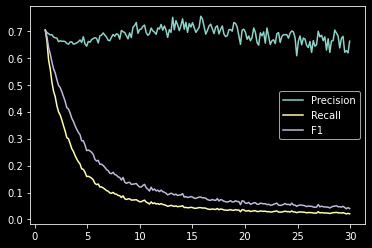

In [61]:
ss.plot()

<AxesSubplot:>

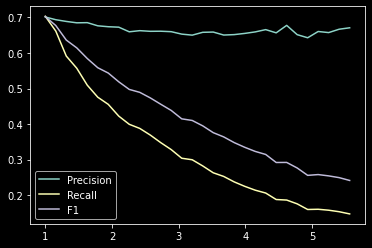

In [62]:
ss.iloc[:30,:].plot()

<AxesSubplot:>

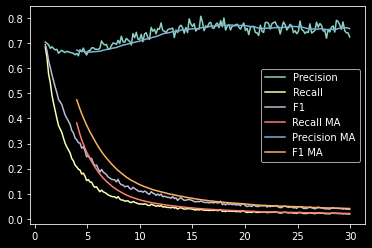

In [21]:
ss['Recall MA'] = ss.Recall.rolling(20).mean()
ss['Precision MA'] = ss.Precision.rolling(20).mean()
ss['F1 MA'] = ss.F1.rolling(20).mean()
ss.plot()

<AxesSubplot:>

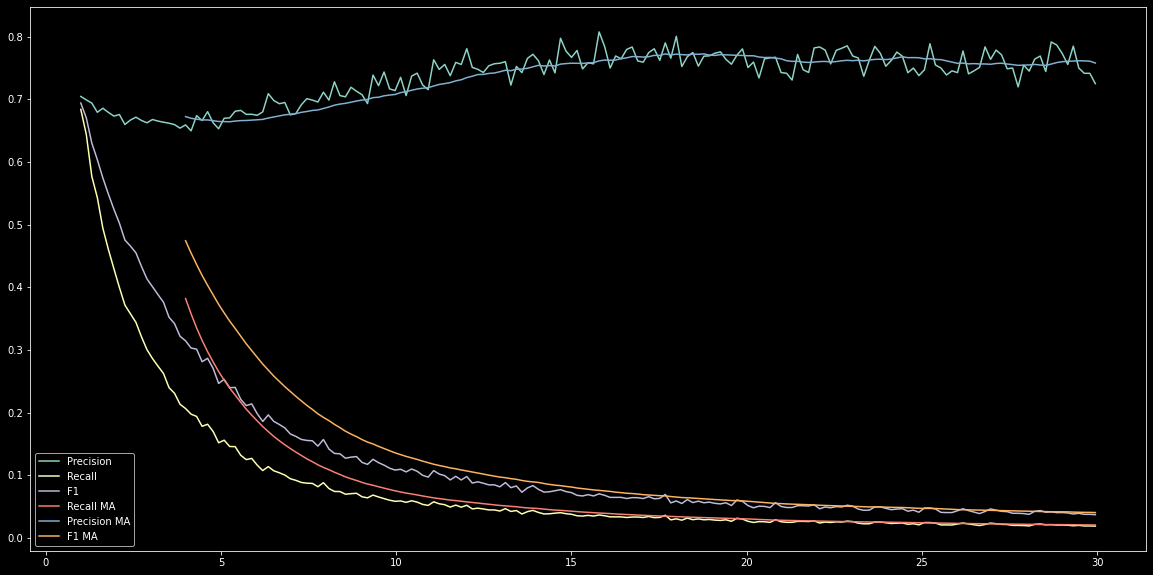

In [22]:
ss.plot(figsize=(20,10))

In [174]:
for_resample[for_resample['y'] == 0]

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,delta,...,gt_2,ft_2,af_2,abspow_2,perm_2,higuchi_2,petrosian_2,median_2,ptp_2,y
0,38,0,0.8647880437,1.4910937857,-0.0310506562,-0.7433318847,0,0.0988636461,1.9312338685,0.0,...,0.0518986192,0.0000006374,0.0000032341,1.1516851935,0.5089234272,1.0820029750,1.0045991567,-0.0000001240,0.0009436247,0
1,38,1,1.3705021084,2.7271315198,0.0694835611,-1.6053364482,0,0.0365860033,5.3244319356,0.0,...,0.3353532861,0.0000027315,0.0000073234,0.5748524379,0.5377557589,1.0755509094,1.0048841654,-0.0000001240,0.0009436247,0
2,38,2,0.6992745830,0.9446039241,0.3773881116,-0.4107206613,0,0.0709305284,3.1596783780,0.0,...,0.1737991472,0.0000060343,0.0000170278,0.1731134842,0.5766995575,1.1222615623,1.0060213861,-0.0000001240,0.0009436247,0
3,38,3,0.5235595704,0.9962790958,0.3845445535,-1.3607682593,0,0.0550887713,3.3096592995,0.0,...,0.0949990319,0.0000126542,0.0000477758,0.0718396937,0.5650541631,1.0858925197,1.0060213861,-0.0000001240,0.0009436247,0
4,38,4,0.8021453315,1.2492180924,0.5310072678,-0.3677069204,0,0.0700528761,2.1895652688,0.0,...,0.2909809039,0.0000093154,0.0000543921,0.1232045079,0.5667319552,1.0698253001,1.0054533371,-0.0000001240,0.0009436247,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104126,429,104126,0.1136325588,0.1918932567,-0.0238064307,-1.0820224266,1,0.0306372785,33.8103025483,0.0,...,0.0289347237,0.0012701860,0.0018719067,0.0018323949,0.9114541592,1.1050312307,1.0312941618,-0.0000003177,0.0009515526,0
104127,429,104127,0.1123106115,0.0996337095,0.7912834398,0.8210874173,0,0.0361095924,24.7690806822,0.0,...,0.0498245937,0.0015142044,0.0024512526,0.0011833061,0.8735704700,1.0915995656,1.0278867787,-0.0000003177,0.0009515526,0
104128,429,104128,0.0705648140,0.1117754423,-0.4496764487,-0.7349754336,0,0.0695764505,11.7132497064,0.0,...,0.0332833858,0.0003696362,0.0009540225,0.0050197960,0.7680306389,1.0986757494,1.0168822598,-0.0000003177,0.0009515526,0
104129,429,104129,0.1701369146,0.2404286859,-0.4764048189,-0.6099120080,0,0.0271003864,33.1987807276,0.0,...,0.1099528154,0.0030611587,0.0092829548,0.0008628618,0.9117545775,1.1214938027,1.0299881121,-0.0000003177,0.0009515526,0


In [175]:
1616959/32000

50.52996875

In [ ]:
joblib.dump(ss, 'ss_ratio_tuning_metrics.pkl')

In [75]:
### only train undersample
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426',
               '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])


X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good,
                                                    random_state=20)

# under sampling non-spikes epochs
X_train['y'] = y_train.astype(int)
feat_0 = X_train[X_train['y'] == 0].sample(n=int(y_train.sum()))
feat_1 = X_train[X_train['y'] == 1].sample(n=int(y_train.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_train = feat_under['y'].to_numpy()
X_train = feat_under.drop('y', axis=1)

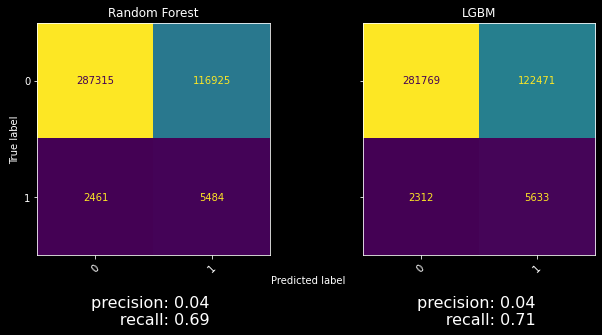

In [76]:
prob = None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

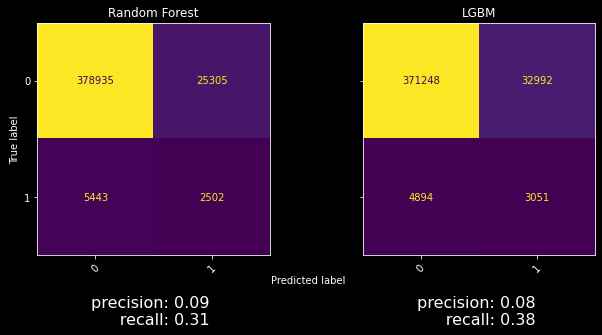

In [77]:
prob = 0.7
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [6]:
### only nrem for train and test
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_nrem[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict_nrem[subj], eog2_dict_nrem[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)


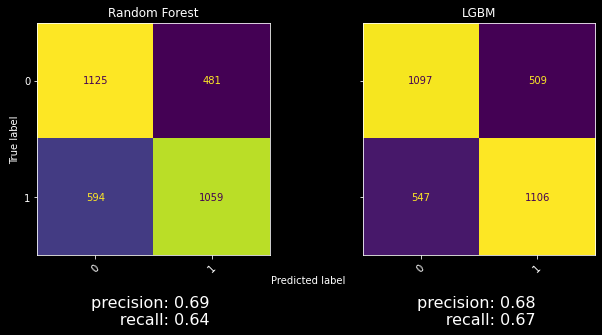

In [7]:
prob = None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

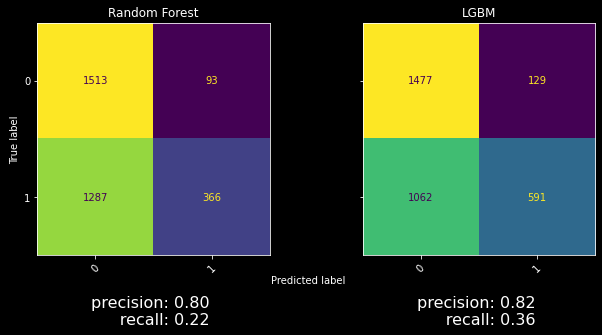

In [8]:
prob = 0.7
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [74]:
X_train[['subj', 'ptp', 'median', 'ptp_2', 'median_2']].drop_duplicates().sort_values(by='subj')

,subj,ptp,median,ptp_2,median_2
27371,38,0.0009550231,-0.0000002905,0.0009436247,-0.0000001240
9505,394,0.0009553177,-0.0000006604,0.0010342035,0.0000003934
28211,396,0.0009084144,0.0000002741,0.0008775677,0.0000001427
24176,398,0.0008656354,-0.0000001369,0.0008439483,0.0000004268
4124,400,0.0009051966,-0.0000005735,0.0008903955,-0.0000002589
14045,402,0.0009817587,0.0000000181,0.0009207651,0.0000000336
33055,404,0.0009675758,-0.0000002365,0.0009199935,-0.0000001388
26448,405,0.0009471835,-0.0000005247,0.0009175622,0.0000001158
22096,406,0.0009231471,-0.0000006014,0.0009812472,0.0000004396
25118,415,0.0009524976,0.0000004677,0.0009138917,0.0000000278


In [27]:
X_train[X_train.subj == '38']['ptp'].iloc[0]

0.0009550231344194584

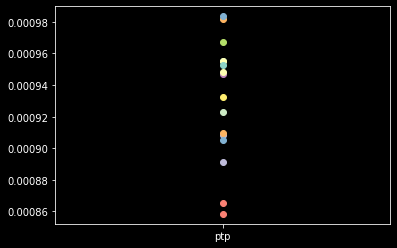

In [29]:
for subj in all_subject:
    plt.scatter(['ptp'], [X_train[X_train.subj == subj]['ptp'].iloc[0]])

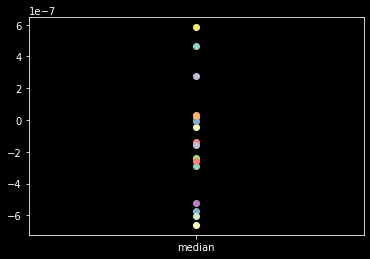

In [30]:
for subj in all_subject:
    plt.scatter(['median'], [X_train[X_train.subj == subj]['median'].iloc[0]])

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

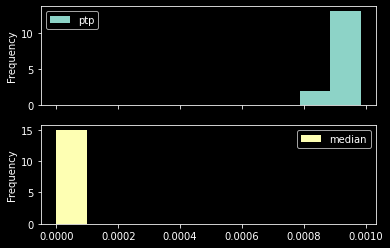

In [72]:
X_train[['subj', 'ptp', 'median']].drop_duplicates().sort_values(by='subj').plot(kind='hist', subplots=True)

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

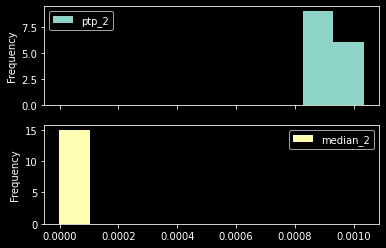

In [73]:
X_train[['subj', 'ptp_2', 'median_2']].drop_duplicates().sort_values(by='subj').plot(kind='hist', subplots=True)

In [64]:
# took forever!!!!
from imblearn.under_sampling import CondensedNearestNeighbour
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426',
               '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

undersample = CondensedNearestNeighbour(n_neighbors=1)
# transform the dataset
X, y = undersample.fit_resample(feat_all_good, y_all_good)

KeyboardInterrupt: 

In [69]:
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426',
               '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

In [71]:
# isolation forest for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(feat_all_good, y_all_good, random_state=2, stratify=y_all_good)
# define outlier detection model
model = IsolationForest(contamination=0.02)
# fit on majority class
trainX = trainX[trainy==0]
model.fit(trainX)
# detect outliers in the test set
yhat = model.predict(testX)
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F1 Score: %.3f' % score)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


F1 Score: 0.040


In [72]:
import datetime
print(datetime.datetime.now())

2023-03-08 11:28:52.402426


In [75]:
yhat[yhat==1]

array([1, 1, 1, ..., 1, 1, 1])

In [76]:
import copy
y_pred = copy.deepcopy(yhat)
y_test = copy.deepcopy(testy)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
y_test[y_test == 1] = 0
y_test[y_test == -1] = 1

Text(0.5, 0, '')

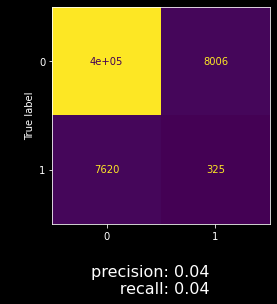

In [77]:
cf_matrix = confusion_matrix(y_test, y_pred)
metrics = get_metrics(cf_matrix)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()
ax = plt.gca()
precision = '{0:.2f}'.format(metrics['precision'])
recall = '{0:.2f}'.format(metrics['recall'])
text = """precision: {0}
                      recall: {1}""".format(precision, recall)
ax.annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
            xytext=(-60, -40), textcoords='offset points',
            ha='right', va='top')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')

In [4]:
X_train

,subj,epoch_id,std,iqr,skew,kurt,nzc,hmob,hcomp,delta,...,gf_2,gt_2,ft_2,af_2,abspow_2,perm_2,higuchi_2,petrosian_2,median_2,ptp_2
87331,423,87331,0.3963460542,0.6277360769,0.3413381216,-1.0323289092,2,0.0414793511,2.3649577784,0.0,...,1752.3083410999,0.0020580056,0.0000011745,0.0000014461,0.1373203589,0.5113879817,1.0217855583,1.0034562841,-0.0000002826,0.0009616930
17077,406,17077,0.3716067162,0.5938619968,0.1437227514,-1.1803939404,2,0.0348072750,4.7714395805,0.0,...,2225.6152431605,0.0238126813,0.0000106994,0.0000147255,0.0449049002,0.5278879263,1.0530929598,1.0040282894,0.0000004396,0.0009812472
33617,404,33617,0.1729909278,0.2687440893,-0.1380460645,-0.9918782796,0,0.0443265239,5.6254878680,0.0,...,246.9919729632,0.0053776035,0.0000217724,0.0000548308,0.0156525935,0.5784793057,1.0577728911,1.0063049914,-0.0000001388,0.0009199935
806,406,806,0.3804834702,0.5055578124,-0.1261265994,-0.5835145671,0,0.0454285339,3.0790940737,0.0,...,1392.1098728752,0.0018909593,0.0000013583,0.0000039196,0.1248932076,0.5028501683,1.0294087031,1.0043138649,0.0000004396,0.0009812472
31341,426,31341,0.0950212184,0.1099174939,-0.1857535051,-0.0022579269,0,0.0779075548,3.0147525837,0.0,...,952.6337577240,0.0180412587,0.0000189383,0.0000282534,0.0108712500,0.5270357844,1.0441386334,1.0045991567,-0.0000000152,0.0009870679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37074,396,37074,0.2158778625,0.3624747847,-0.6522081690,-0.9112906724,2,0.0417409811,5.8464257646,0.0,...,65.7982096277,0.0045947468,0.0000698309,0.0001086746,0.0208641747,0.4703785777,1.0191727650,1.0034562841,0.0000001427,0.0008775677
94627,396,94627,0.0683067120,0.0871146903,0.6339633596,-0.2184217198,0,0.0801061526,4.5881432363,0.0,...,92.9096014720,0.0035618924,0.0000383372,0.0000639632,0.0163144121,0.6258023952,1.0466990889,1.0082824745,0.0000001427,0.0008775677
81725,416,81725,0.0649282477,0.1014354515,0.1801293005,-0.8538102642,0,0.0736768714,8.5827659419,0.0,...,57.6169424421,0.0025324974,0.0000439540,0.0001710814,0.0159908093,0.7669934568,1.0430870469,1.0171555328,-0.0000001294,0.0008581820
62912,415,62912,0.1070993391,0.1702806723,-0.1962176023,-0.7293492539,0,0.0797426749,2.6321581082,0.0,...,493.1271037139,0.0380214155,0.0000771027,0.0000775071,0.0105827201,0.6038029789,1.0392871787,1.0071541399,0.0000000278,0.0009138917


In [27]:
# EOG 1+2, under sample
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426',
               '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

for subj in ['013', '017', '025']:
    y_subj = get_all_y_AH(subjects=[subj])
    clear_output()
    y_all_good = np.concatenate([y_all_good, y_subj])
    feat_eog1 = get_all_feat_eog_with_chan_feat('1', subjects=[subj])
    clear_output()
    feat_eog2 = get_all_feat_eog_with_chan_feat('2', subjects=[subj])
    clear_output()
    subj_feat = pd.concat([feat_eog1, feat_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, subj_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'],
                                                    random_state=20)


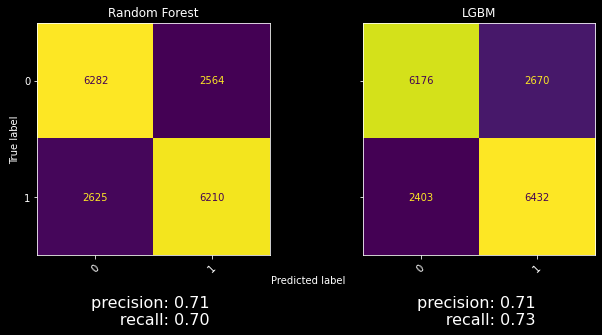

In [29]:
prob = None
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

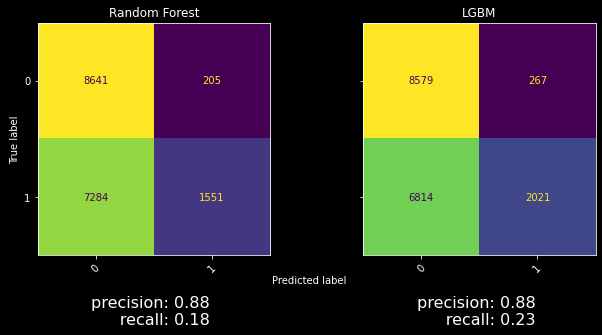

In [30]:
prob = 0.8
# without selector
x_train_data = X_train.iloc[:, 2:]
x_test_data = X_test.iloc[:, 2:]

f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 19 artists>

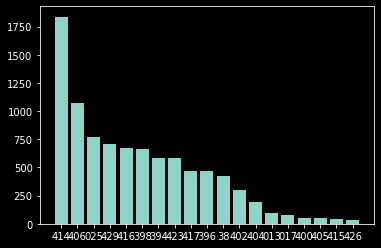

In [31]:
details = pred_details['LGBM']
data = details[(details['pred'] >= 0.8)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

In [28]:
# dump full model
x_train_data = feat_all_good.iloc[:, 2:]
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.fit(x_train_data, y_all_good)

joblib.dump(classifiers['Random Forest'], 'rf_under_19.pkl')
joblib.dump(classifiers['LGBM'], 'lgbm_under_19.pkl')

['lgbm_under_19.pkl']